In [95]:
# Imports

import numpy as np
import logging; logger = logging.getLogger(__name__)


from opendrift.models.oceandrift import OceanDrift, Lagrangian3DArray
from opendrift.models.leeway import Leeway # For Search and Rescure. May not be relevant
from opendrift.models.plastdrift import PlastDrift
from opendrift.models.sedimentdrift import SedimentDrift # Looks most promising
from opendrift.models.radionuclides import Radionuclide

from opendrift.readers import reader_netCDF_CF_generic

from pprint import pprint
from opendrift.readers import reader_global_landmask

from datetime import datetime

from opendrift.models.basemodel import OpenDriftSimulation
from opendrift.elements import LagrangianArray


### Define the model

Here, we define the class *GhostNetElement*, which is supposed to represent a single ghost net in the ocean. Then, the class *GhostNetDrift* handles the simulation. <br>

As of now, I simply copied the code from `opendrift.models.sedimentdrift.SedimentDrift`. We should also check out `opendrift.models.radionnuclides.Radionnuclide` as it also incorporates diameter, density, etc. Then, the RadionNuclideDrift shows how these properties can be handled in the simulation. <br>

The most important parts here are the `variables` field in GhostNetElement, the `required_variables` field in GhostNetDrift and the `update()` function in GhostNetDrift.

In [96]:
class GhostNetElement(Lagrangian3DArray):
    variables = Lagrangian3DArray.add_variables([
        ('settled', {'dtype': np.uint8,  # 0 is active, 1 is settled
                     'units': '1',
                     'default': 0}),
        ('terminal_velocity', {'dtype': np.float32,
                               'units': 'm/s',
                               'default': -0.001})  # 1 mm/s negative buoyancy
        ])

# Differences between RadionNuclide and Sediment:
# diameter in radionuclide: BUT only needed to update terminal velocity (don't include)
# density: -------||---------


class GhostNetDrift(OceanDrift):
    """Model for sediment drift, under development
    """

    ElementType = GhostNetElement

    required_variables = {
        'x_sea_water_velocity': {'fallback': 0},
        'y_sea_water_velocity': {'fallback': 0},
        'upward_sea_water_velocity': {'fallback': 0},
        'x_wind': {'fallback': 0},
        'y_wind': {'fallback': 0},
        'sea_surface_wave_stokes_drift_x_velocity': {'fallback': 0},
        'sea_surface_wave_stokes_drift_y_velocity': {'fallback': 0},
        'sea_surface_wave_period_at_variance_spectral_density_maximum': {'fallback': 0},
        'sea_surface_wave_mean_period_from_variance_spectral_density_second_frequency_moment': {'fallback': 0},
        'land_binary_mask': {'fallback': None},
        'ocean_vertical_diffusivity': {'fallback': 0.02},
        'ocean_mixed_layer_thickness': {'fallback': 50},
        'sea_floor_depth_below_sea_level': {'fallback': 0},
        }

    def __init__(self, *args, **kwargs):
        """ Constructor of SedimentDrift module
        """

        super(GhostNetDrift, self).__init__(*args, **kwargs)

        # By default, sediments do not strand towards coastline
        # TODO: A more sophisticated stranding algorithm is needed
        self._set_config_default('general:coastline_action', 'previous')

        # Vertical mixing is enabled as default
        self._set_config_default('drift:vertical_mixing', True)

        # To allow stranding particles
        self._set_config_default('general:coastline_action', 'stranding')

    def update(self):
        """Update positions and properties of sediment particles.
        """

        # Advecting here all elements, but want to soon add
        # possibility of not moving settled elements, until
        # they are resuspended. May then need to send a boolean
        # array to advection methods below
        self.advect_ocean_current()

        self.vertical_advection()

        self.advect_wind()  # Wind shear in upper 10cm of ocean

        self.stokes_drift()

        #self.vertical_mixing()  # Including buoyancy and settling

        self.resuspension()

    def bottom_interaction(self, seafloor_depth):
        """Sub method of vertical_mixing, determines settling"""
        # Elements at or below seafloor are settled, by setting
        # self.elements.moving to 0.
        # These elements will not move until eventual later resuspension.
        settling = np.logical_and(self.elements.z <= seafloor_depth, self.elements.moving==1)
        if np.sum(settling) > 0:
            logger.debug('Settling %s elements at seafloor' % np.sum(settling))
            self.elements.moving[settling] = 0

    def resuspension(self):
        """Resuspending elements if current speed > .5 m/s"""
        resuspending = np.logical_and(self.current_speed()>.5, self.elements.moving==0)
        if np.sum(resuspending) > 0:
            # Allow moving again
            self.elements.moving[resuspending] = 1
            # Suspend 1 cm above seafloor
            self.elements.z[resuspending] = self.elements.z[resuspending] + .01


In [97]:
#o = GhostNetDrift(loglevel=0)

# Want to try different models:
# Plastic
o = PlastDrift()
o.set_config('general:coastline_action', 'stranding')

11:24:26 DEBUG   opendrift.models.oceandrift:112: No machine learning correction available.
11:24:26 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
11:24:26 DEBUG   opendrift.models.basemodel:618: Adding 5 config items from basemodel
11:24:26 DEBUG   opendrift.models.basemodel:618: Adding 22 config items from basemodel
11:24:27 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.6 / v1.10.6-5-ged278b2)
11:24:27 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
11:24:27 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z
11:24:27 DEBUG   opendrift.models.basemodel:618: Adding 1 config items from plastdrift


In [98]:
pprint(o.required_variables)

{'land_binary_mask': {'fallback': None},
 'ocean_mixed_layer_thickness': {'fallback': 50},
 'ocean_vertical_diffusivity': {'fallback': 0.02, 'profiles': True},
 'sea_floor_depth_below_sea_level': {'fallback': 10000},
 'sea_surface_wave_significant_height': {'fallback': 0},
 'sea_surface_wave_stokes_drift_x_velocity': {'fallback': 0},
 'sea_surface_wave_stokes_drift_y_velocity': {'fallback': 0},
 'x_sea_water_velocity': {'fallback': 0},
 'x_wind': {'fallback': 0},
 'y_sea_water_velocity': {'fallback': 0},
 'y_wind': {'fallback': 0}}


### Add Readers. There are two readers of interest: 
- Generic reader that retrieves ocean data for simulating currents
- Landmask reader for land data (where ocean meets land). This file is simply 3D tensor (matrix) containing 1 where there is land and 0 where there is ocean <br>

Each reader needs a filename, that is either a local file or URL. Here I use the URL provided [here](https://opendrift.github.io/tutorial.html#import-a-specific-model-for-the-relevant-application) <br>

**They are accessed in the following manner:**

In [99]:



# Generic reader
reader_norkyst = reader_netCDF_CF_generic.Reader(
    filename='https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be'
)

# Landmask reader. 
reader_landmask = reader_global_landmask.Reader()

11:24:29 INFO    opendrift.readers.reader_netCDF_CF_generic:138: Opening dataset: https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be
11:24:30 DEBUG   opendrift.readers.reader_netCDF_CF_generic:155: Finding coordinate variables.
11:24:30 DEBUG   opendrift.readers.reader_netCDF_CF_generic:355: Skipped variables without standard_name: ['angle', 'tke', 'ubar', 'vbar']
11:24:30 DEBUG   opendrift.readers.basereader.variables:546: Setting buffer size 25 for reader https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be, assuming a maximum average speed of 5 m/s and time span of 1:00:00
11:24:30 DEBUG   opendrift.readers.basereader:168: Variable mapping: ['sea_floor_depth_below_sea_level'] -> ['land_binary_mask'] is not activated
11:24:30 DEBUG   opendrift.readers.basereader:168: Variable mapping: ['sea_floor_depth_below_sea_level'] -> ['land_binary_mask'] is not activated


In [100]:
print(reader_norkyst)

Reader: https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be
Projection: 
  +proj=stere +lat_0=90 +lat_ts=60 +lon_0=70 +x_0=3192800 +y_0=1784000 +a=6378137 +b=6356752.3142 +units=m +no_defs +type=crs
Coverage: [degrees]
  xmin: 0.000000   xmax: 2080800.000000   step: 800   numx: 2602
  ymin: 0.000000   ymax: 720800.000000   step: 800   numy: 902
  Corners (lon, lat):
    ( -1.58,  58.50)  ( 23.71,  75.32)
    (  9.19,  55.91)  ( 38.06,  70.03)
Vertical levels [m]: 
  [   -0.    -3.   -10.   -15.   -25.   -50.   -75.  -100.  -150.  -200.
  -250.  -300.  -500. -1000. -2000. -3000.]
Available time range:
  start: 2017-02-20 00:00:00   end: 2023-04-24 00:00:00   step: 1:00:00
    54097 times (3240 missing)
Variables:
  sea_floor_depth_below_sea_level
  latitude
  longitude
  x_wind
  y_wind
  sea_water_salinity
  sea_water_temperature
  x_sea_water_velocity
  eastward_sea_water_velocity
  y_sea_water_velocity
  northward_sea_water_velocity
  upward_sea_water_velocity
  sea_

In [101]:

o.add_reader([reader_landmask, reader_norkyst])

11:24:31 DEBUG   opendrift.models.basemodel:945: Added reader global_landmask
11:24:31 DEBUG   opendrift.readers.basereader.variables:546: Setting buffer size 7 for reader https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be, assuming a maximum average speed of 1 m/s and time span of 1:00:00
11:24:31 DEBUG   opendrift.models.basemodel:945: Added reader https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be


### Getting number and position of particles
Using data for fishing activity over the timespan 2021-2022 to estimate the placement and number of particles released. Count any activity over half an hour, then release another particle for every 10 hours of activity. Can change this number.

In [102]:
# Want to get the position of the particles from GlobalFishingWatch
import pandas as pd
fishing_activity_21_22 = pd.read_csv("Fishing_activity_2021-2022.csv", delimiter=';', header=0,usecols=[0,1,3,4], low_memory=False)
fa_gill_nets = fishing_activity_21_22[fishing_activity_21_22['geartype'] == 'set_gillnets']
# Filter out fishing activity under 0.5 hours:
fa_gill_nets = fa_gill_nets[fa_gill_nets['Apparent Fishing hours'] > 0.5]
fa_gill_nets['num_particles'] = fa_gill_nets['Apparent Fishing hours']//10+1

In [103]:
# Only southern Norway (South of Namsos)
fa_gill_nets_south = fa_gill_nets[fa_gill_nets["Lat"]<64]
print(sum(fa_gill_nets_south["num_particles"]))
print(sum(fa_gill_nets["num_particles"]))

14980.0
75758.0


In [104]:
#parts_lists = np.ones(fa_gill_nets_south['num_particles'])
lats = fa_gill_nets_south['Lat']#*np.ones(fa_gill_nets_south['num_particles'])
lats = np.array(lats)
lons = fa_gill_nets_south['Lon']#*np.ones(fa_gill_nets_south['num_particles'])
lons = np.array(lons)
num_parts = fa_gill_nets_south['num_particles']
num_parts = np.array(num_parts)
print(lats)
print(num_parts)

lats_total = []
lons_total = []
for i in range(len(num_parts)):
    for j in range(int(num_parts[i])):
        lats_total.append(lats[i])
        lons_total.append(lons[i])
lats_total = np.array(lats_total)
lons_total = np.array(lons_total)


[60.1  58.35 63.7  ... 63.02 62.93 62.99]
[1. 1. 1. ... 1. 1. 1.]


lats_total and lons_total are the coordinates of the particles being released. Where multiple particles should be placed in the same spot, there are multiples of the same latitude and longitude.

### Seeding elements
To seed an element simply means releasing it into the ocean (for simulation). <br>

**Important:**
- If `lon` and `lat` are given as arrays of two elements, the GhostNet is dropped randomly at the line between them. Here, the radius can incorporate the uncertainty of the line's width. 
- If `time` is given as an array, then the GhostNet is dropped randomly in the timeinterval. 

In [109]:
from random import randrange
from datetime import timedelta

def random_date(start, end):
    """
    This function will return a random datetime between two datetime 
    objects.
    """
    delta = end - start
    int_delta = (delta.days * 24 * 60 * 60) + delta.seconds
    random_second = randrange(int_delta)
    return start + timedelta(seconds=random_second)

start_date = datetime.strptime('1/1/2021', '%m/%d/%Y')
end_date = datetime.strptime('1/1/2023', '%m/%d/%Y')

sim_start = random_date(start_date, end_date)
sim_start

datetime.datetime(2021, 9, 15, 6, 20, 57)

In [182]:
fa_gill_nets_south

,Lat,Lon,geartype,Apparent Fishing hours,num_particles
358541,60.10,6.11,set_gillnets,0.941908,1.0
358544,58.35,8.66,set_gillnets,2.408611,1.0
358545,63.70,9.07,set_gillnets,1.782222,1.0
358548,63.33,7.75,set_gillnets,7.704144,1.0
358552,60.18,5.73,set_gillnets,3.195556,1.0
...,...,...,...,...,...
429606,62.93,5.42,set_gillnets,0.983056,1.0
429607,63.03,5.48,set_gillnets,1.990000,1.0
429608,63.02,5.55,set_gillnets,1.549722,1.0
429609,62.93,5.50,set_gillnets,1.043611,1.0


In [118]:
# These are the standard arguments. 
# number GhostNet is dropped at longitude 4.3, lattitude 60 within a radius of 1000 meters. 
#o.seed_elements(lon=4.5, lat=60, radius=1000, number=10, time=reader_norkyst.start_time)

# Try to seed with the actual particles

o = PlastDrift()
o.set_config('general:coastline_action', 'stranding')
# Generic reader
reader_norkyst = reader_netCDF_CF_generic.Reader(
    filename='https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be'
)

# Landmask reader. 
reader_landmask 

o.add_reader([reader_landmask, reader_norkyst])

lons = fa_gill_nets_south.Lon.values
lats = fa_gill_nets_south.Lat.values
n_particles = fa_gill_nets_south.num_particles.values

o.seed_elements(lon=lons, lat=lats, number=n_particles, time=sim_start, radius=1000)

11:51:09 DEBUG   opendrift.models.oceandrift:112: No machine learning correction available.
11:51:09 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
11:51:09 DEBUG   opendrift.models.basemodel:618: Adding 5 config items from basemodel
11:51:09 DEBUG   opendrift.models.basemodel:618: Adding 22 config items from basemodel
11:51:09 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.6 / v1.10.6-5-ged278b2)
11:51:09 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
11:51:09 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z
11:51:09 DEBUG   opendrift.models.basemodel:618: Adding 1 config items from plastdrift
11:51:09 INFO    opendrift.readers.reader_netCDF_CF_generic:138: Opening dataset: https://thredds.met.no/thredds/dodsC/sea/norkyst800m/1h/aggregate_be
11:51:29 DEBUG   opendrift.readers.reader_netCDF_CF_generic:155: Finding coordinate variables.
11:51:29 DEBUG   opendrift

### Configurating the simulation

We can also provide custom configurations to the simulation, that may suit GhostNets better.

In [123]:
# Parameters available to configurate:
#o.list_configspec()

general:use_auto_landmask           [True] bool   A built-in GSHHG glo...
general:coastline_action            [stranding] enum  ['none', 'stranding', 'previous'] None means that obje...
general:time_step_minutes           [60] float min: 0.01, max: 1440 [minutes] Calculation time ste...
general:time_step_output_minutes    [None] float min: 1, max: 1440 [minutes] Output time step, i....
seed:ocean_only                     [True] bool   If True, elements se...
seed:number                         [1] int   min: 1, max: 100000000 [1] The number of elemen...
drift:max_age_seconds               [None] float min: 0, max: inf [seconds] Elements will be dea...
drift:advection_scheme              [euler] enum  ['euler', 'runge-kutta', 'runge-kutta4'] Numerical advection ...
drift:current_uncertainty           [0] float min: 0, max: 5 [m/s] Add gaussian perturb...
drift:current_uncertainty_uniform   [0] float min: 0, max: 5 [m/s] Add gaussian perturb...
drift:horizontal_diffusivity        [0] flo

### Running the model

In [183]:
# Set points to stop when hitting coastline
o.set_config('general:coastline_action', 'stranding')


In [125]:
# Variables the simulation needs
o.required_variables

{'x_sea_water_velocity': {'fallback': 0},
 'y_sea_water_velocity': {'fallback': 0},
 'sea_surface_wave_stokes_drift_x_velocity': {'fallback': 0},
 'sea_surface_wave_stokes_drift_y_velocity': {'fallback': 0},
 'sea_surface_wave_significant_height': {'fallback': 0},
 'x_wind': {'fallback': 0},
 'y_wind': {'fallback': 0},
 'ocean_vertical_diffusivity': {'fallback': 0.02, 'profiles': True},
 'ocean_mixed_layer_thickness': {'fallback': 50},
 'sea_floor_depth_below_sea_level': {'fallback': 10000},
 'land_binary_mask': {'fallback': None}}

In [126]:
# Hover over run to see documentation
#o.run(time_step=3600, steps=1)
o.run(time_step=3600,steps=24, outfile='sim_1_day_plastic.nc')

11:52:21 DEBUG   opendrift.models.basemodel:2533: 
------------------------------------------------------
Software and hardware:
  OpenDrift version 1.10.6
  Platform: Darwin, 22.3.0
  64.0 GB memory
  10 processors (i386)
  NumPy version 1.24.2
  SciPy version 1.10.1
  Matplotlib version 3.7.1
  NetCDF4 version 1.6.3
  Xarray version 2023.3.0
  Python version 3.11.3 | packaged by conda-forge | (main, Apr  6 2023, 09:05:00) [Clang 14.0.6 ]
------------------------------------------------------

11:52:21 INFO    opendrift.models.basemodel:2579: Fallback values will be used for the following variables which have no readers: 
11:52:21 INFO    opendrift.models.basemodel:2582: 	sea_surface_wave_stokes_drift_x_velocity: 0.000000
11:52:21 INFO    opendrift.models.basemodel:2582: 	sea_surface_wave_stokes_drift_y_velocity: 0.000000
11:52:21 INFO    opendrift.models.basemodel:2582: 	sea_surface_wave_significant_height: 0.000000
11:52:21 INFO    opendrift.models.basemodel:2582: 	ocean_vertical_di

11:58:46 DEBUG   opendrift.models.basemodel:3168: Setting up map: corners=None, fast=False, lscale=None
11:58:46 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (1.7949088573455814, 11.489600563049317, 56.51133041381834, 64.36349792480468)..
11:59:01 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (1.7949088573455814, 11.489600563049317, 56.51133041381834, 64.36349792480468)..
11:59:06 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (1.7949088573455814, 11.489600563049317, 56.51133041381834, 64.36349792480468)..


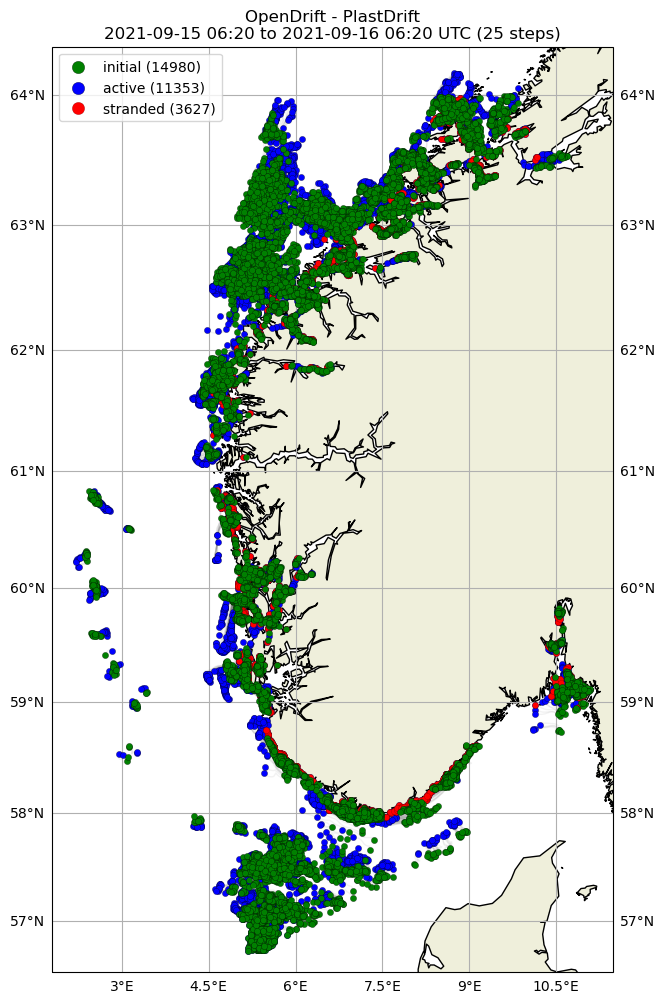

(<GeoAxes: title={'center': 'OpenDrift - PlastDrift\n2021-09-15 06:20 to 2021-09-16 06:20 UTC (25 steps)'}>,
 <Figure size 670.06x1100 with 1 Axes>)

In [127]:
o.plot()

Can save the simulation data to file on .nc format.

In [ ]:
# Importing data for simulation instead of running it again.

# o = PlastDrift(loglevel=0)
# o.io_import_file('sim_1_day.nc')

10:35:22 DEBUG   opendrift.models.oceandrift:112: No machine learning correction available.
10:35:22 DEBUG   opendrift.models.basemodel:618: Adding 17 config items from basemodel
10:35:22 DEBUG   opendrift.models.basemodel:618: Adding 6 config items from basemodel
10:35:22 DEBUG   opendrift.models.basemodel:618: Adding 26 config items from basemodel
10:35:22 INFO    opendrift.models.basemodel:532: OpenDriftSimulation initialised (version 1.10.6 / v1.10.6-5-ged278b2)
10:35:22 DEBUG   opendrift.models.basemodel:618: Adding 14 config items from oceandrift
10:35:22 DEBUG   opendrift.models.basemodel:630:   Overwriting config item seed:z
10:35:22 DEBUG   opendrift.export.io_netcdf:267: Importing from sim_1_day.nc
10:35:22 DEBUG   opendrift.models.basemodel:2458: Removed 3212 elements.
10:35:22 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:use_auto_landmask -> True
10:35:22 DEBUG   opendrift.export.io_netcdf:365: Setting imported config: general:coastline_action ->

11:59:31 DEBUG   opendrift.models.basemodel:3168: Setting up map: corners=None, fast=False, lscale=None
11:59:31 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (1.7949088573455814, 11.489600563049317, 56.51133041381834, 64.36349792480468)..
11:59:45 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (1.7949088573455814, 11.489600563049317, 56.51133041381834, 64.36349792480468)..
11:59:50 DEBUG   opendrift.readers.reader_global_landmask:83: Adding GSHHG shapes from cartopy, scale: i, extent: (1.7949088573455814, 11.489600563049317, 56.51133041381834, 64.36349792480468)..


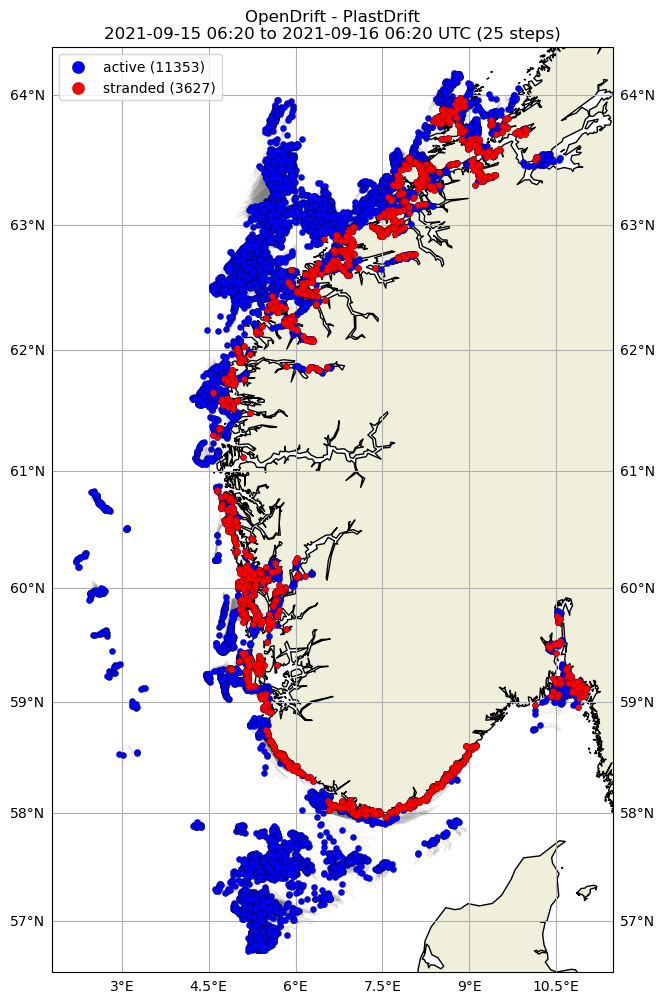

(<GeoAxes: title={'center': 'OpenDrift - PlastDrift\n2021-09-15 06:20 to 2021-09-16 06:20 UTC (25 steps)'}>,
 <Figure size 670.06x1100 with 1 Axes>)

In [128]:
o.plot(show_initial=False)

In [154]:
# Using netCDF4

import netCDF4 as nc
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

ID: []
status: []
moving: []
age_seconds: []
origin_marker: []
lon: []
lat: []
z: []
wind_drift_factor: []
current_drift_factor: []
terminal_velocity: []

In [155]:
lon_active, lat_active = o.elements.lon.data, o.elements.lat.data
lon_deactive, lat_deactive = o.elements_deactivated.lon.data, o.elements_deactivated.lat.data

active_points = pd.DataFrame({'lat': lat_active, 'lon': lon_active})
deactive_points = pd.DataFrame({'lat': lat_deactive, 'lon': lon_deactive})

In [159]:
fig = px.scatter_mapbox(active_points, lat='lat', lon='lon', mapbox_style='open-street-map')

fig.add_trace(go.Scattermapbox(
    lat=deactive_points['lat'],
    lon=deactive_points['lon']
))
fig.update_layout(title = 'Congregation of nets', title_x=0.5)
fig.show()

In [161]:
%pip install scikit-learn

  Using cached scikit_learn-1.2.2-cp311-cp311-macosx_10_9_x86_64.whl (9.0 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [162]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(deactive_points)

In [177]:
fig = px.scatter_mapbox(deactive_points, lat='lat', lon='lon', color=np.exp(kde.score_samples(deactive_points)), mapbox_style='open-street-map')
fig.show()